In [6]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

import pickle

torch.manual_seed(0)
np.random.seed(0)

In [7]:
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 15 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [8]:
################################################################
# configs
################################################################
DATA_PATH = 'inverse/melt_fluidity.npy'

# currently data are 100 samples
ntrain = 80
ntest = 20

modes = 8
width = 20

batch_size = 10

epochs = 100
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = f'melt_fluidity_ep{epochs}'
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

runtime = np.zeros(2, )
t1 = default_timer()

S1 = 65
S2 = 97
T_in = 2
T = 2
step = 1

100 0.001 100 0.5


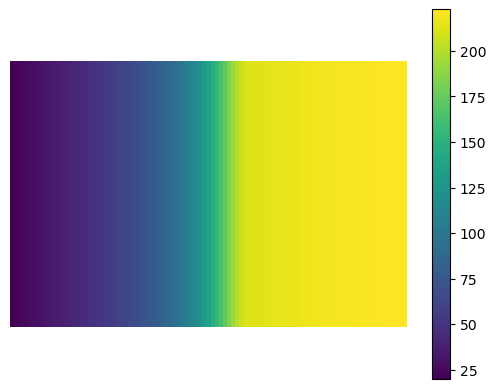

torch.Size([80, 65, 97, 2])
torch.Size([20, 65, 97, 2])
preprocessing finished, time used: 0.1381969320063945


In [9]:
################################################################
# load data
################################################################
data_gen = np.load(DATA_PATH)
np.random.shuffle(data_gen)

cp = plt.imshow(data_gen[0,:,:,2])
plt.colorbar(cp)
plt.axis("off")
plt.show()

train_a = torch.tensor(data_gen[:ntrain,:,:,:T_in], dtype=torch.float)
train_u = torch.tensor(data_gen[:ntrain,:,:,T_in:T+T_in], dtype=torch.float)

test_a = torch.tensor(data_gen[-ntest:,:,:,:T_in], dtype=torch.float)
test_u = torch.tensor(data_gen[-ntest:,:,:,T_in:T+T_in], dtype=torch.float)

print(train_a.shape)
print(test_u.shape)
assert (S1 == train_u.shape[-3])
assert (S2 == train_u.shape[-2])
assert (T == train_u.shape[-1])


a_normalizer = UnitGaussianNormalizer(train_a)
# with open('a_normalizer_melt_fluidity.pkl', 'wb') as f:
#     pickle.dump(a_normalizer, f)

train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
# with open('y_normalizer_melt_fluidity.pkl', 'wb') as f:
#     pickle.dump(y_normalizer, f)

train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S1,S2,2,1).repeat([1,1,1,1,1])
test_a = test_a.reshape(ntest,S1,S2,2,1).repeat([1,1,1,1,1])

# train_a = train_a.reshape(ntrain,S1,S2,T_in)
# test_a = test_a.reshape(ntest,S1,S2,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

In [10]:
################################################################
# training and evaluation
################################################################
model = FNO3d(modes, modes, modes, width).cuda()

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S1, S2, 2)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S1, S2, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)
# torch.save(model, path_model)

6558357
0 1.2104651179979555 0.9791137836873531 0.09471189826726914 0.08793796300888061
1 1.0668042860052083 0.9898343831300735 0.09313040673732757 0.08974159955978393
2 1.03986586802057 0.9902067556977272 0.09144784584641456 0.09063263833522797
3 1.0516765379870776 0.964591458439827 0.08913560658693313 0.08915000855922699
4 1.0254836289968807 0.7506796345114708 0.07873612120747567 0.06686466932296753
5 1.0433090370206628 0.34673590399324894 0.0550445556640625 0.04515438973903656
6 1.052232477988582 0.19816239178180695 0.038765699788928035 0.026344093680381774
7 0.9936377600242849 0.14483923465013504 0.025743988528847694 0.01684068962931633
8 1.0039522710139863 0.12770242150872946 0.016390616819262505 0.013656449690461158
9 1.0157001690240577 0.11529904883354902 0.01575884371995926 0.013135155290365219
10 1.0227133189910091 0.0986575623974204 0.01504013016819954 0.011506962031126023
11 1.0035980300162919 0.08532320195809007 0.01219686409458518 0.009479266405105592
12 1.0168772299948614

KeyboardInterrupt: 

torch.Size([20, 65, 97, 2])
0 0.006507631856948137
1 0.010904030874371529
2 0.0038635097444057465
3 0.005710519850254059
4 0.011937791481614113
5 0.005773245822638273
6 0.011247034184634686
7 0.0023115593940019608
8 0.008157579228281975
9 0.0028878124430775642
10 0.006738496944308281
11 0.009024073369801044
12 0.008393196389079094
13 0.0072569288313388824
14 0.00792486872524023
15 0.002267736941576004
16 0.0034472253173589706
17 0.006098336074501276
18 0.006859935820102692
19 0.0054424600675702095


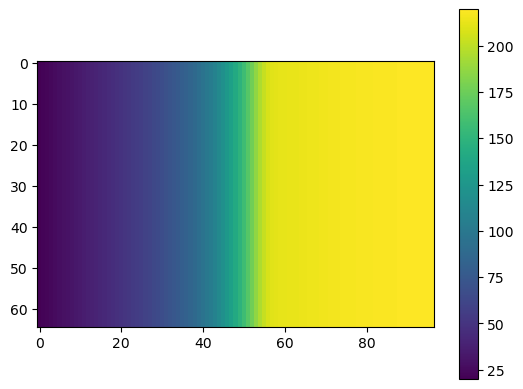

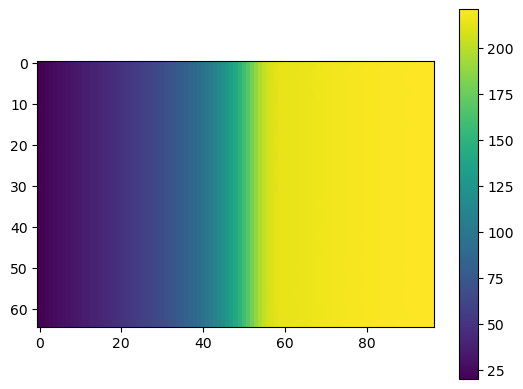

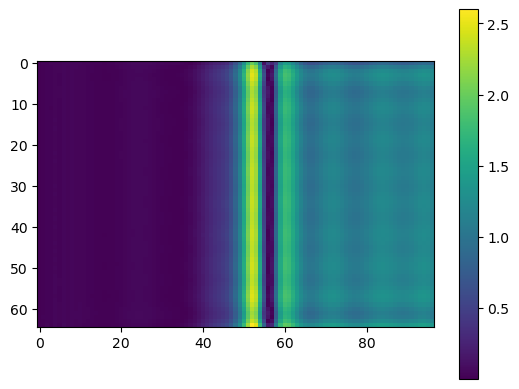

In [ ]:
pred = torch.zeros(test_u.shape)
print(pred.shape)
index = 0
# model = torch.load("model/friction_ep500")
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
first_output = 0

with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        if index == 3:
            first_output = y.clone()
        x, y = x.cuda(), y.cuda()
        out = model(x)
        out = y_normalizer.decode(out[:,:,:,0])
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index+=1
        # cp = plt.imshow(pred[index])
        # plt.colorbar(cp)
        # plt.show()

# for i in range(18):
#     cp = plt.imshow(abs(pred[0,:,:,i]-first_output[0,:,:,i]))
#     plt.colorbar(cp)
#     plt.show()
#     print(i)
    # cp = plt.imshow(first_output[0,:,:,i])
    # plt.colorbar(cp)
    # plt.show()

cp = plt.imshow(first_output[0,:,:,1])
plt.colorbar(cp)
plt.show()

cp = plt.imshow(pred[3,:,:,1])
plt.colorbar(cp)
plt.show()

cp = plt.imshow(abs(pred[3,:,:,0]-first_output[0,:,:,1]))
plt.colorbar(cp)
plt.show()

# cp = plt.imshow(pred[0,:,:,9])
# plt.colorbar(cp)
# plt.show()
# cp = plt.imshow(pois_output[0,:,:,0])
# plt.colorbar(cp)
# plt.show()

# cp = plt.imshow(abs(pred[index][:,:,0] - pois_output[0,:,:,0]))
# plt.colorbar(cp)
# plt.show()
